In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
import numpy as np


class DNNRegressor:
    """
    Implements a first-order differential Nearest Neighbours regressor (introduced in 2205.08434).
    Multivariable regression is allowed. 
    Parameters:
        n_neighbors - number of nearest neighbours, same as in usual kNN.
        n_derivative_neigbors - number of those neighbours' neighbours, used to estimate the regression function's gradient at each neigbour. 
    Returns: 
        DNNRegressor object with fit, predict methods. 
    """
    def __init__(self, n_neighbors=5, n_derivative_neighbors=5) -> None:
        self.n_neighbors = n_neighbors
        self.n_derivative_neighbors = n_derivative_neighbors
        self.X = None
        self.y = None
        
        if self.n_neighbors == self.n_derivative_neighbors: 
            # reuse kNN instance if n_neighbors=n_derivative_neighbors
            self.knnmodel = NearestNeighbors(n_neighbors=self.n_neighbors)
            self.d_knnmodel = self.knnmodel
        else:
            self.knnmodel = NearestNeighbors(n_neighbors=self.n_neighbors)
            self.d_knnmodel = NearestNeighbors(n_neighbors=self.n_derivative_neighbors)
        
    
    def _grad_at_point(self,y_col,point_id,id2neighbor_ids):
        """
        Return gradient at point with id point_id.
        """
        point = self.X[point_id]
        label = y_col[point_id]
        neighbour_ids = id2neighbor_ids[point_id]
        neighbours = self.X[neighbour_ids]
        neighbour_labels = y_col[neighbour_ids]
        
        x_diff = ( neighbours - point )
        x_diff_norm = np.linalg.norm( x=x_diff, axis = 1 )
        y_diff = ( neighbour_labels - label  )
        
        w = np.ones(x_diff.shape[0])
        solver = Ridge(
                        alpha=1e-6,
                        tol=1e-12,
                        fit_intercept=False,
                    ).fit((x_diff.T/x_diff_norm).T, y_diff/x_diff_norm, sample_weight=w)
        return solver.coef_

    def _get_grads(self,y_col,neighbour_ids,id2neighbor_ids):
        grads = []
        for id in neighbour_ids:
            grads.append( self._grad_at_point( y_col,id,id2neighbor_ids) )
        return np.array(grads)

    def _get_neighbour_ids(self, point, model):
        
        # TO DO: case when predict_point is called 
        # on an already existing point.
        
        #if point not in self.X:
            distances, point_neighbour_ids = model.kneighbors(point)
            return point_neighbour_ids.squeeze(0)
        #else:
        #    return id2neighbor_ids[ np.argwhere(self.X == point)[0][0] ]

    def fit(self, X, y):
        """
        Fits the DNNRegressor instance. 
        Fits the scikit-learn NearestNeighbors instances and initialises necessary nearest neighbour arrays.
        """
        self.X = np.array(X)
        self.y = np.array(y)
        if self.y.ndim == 1: #univariable case
            self.y = np.expand_dims(self.y,1)
        if self.n_neighbors == self.n_derivative_neighbors:
            self.knnmodel = self.knnmodel.fit(self.X,self.y)
            self.id2neighbor_ids = {id:neighbour_ids for id, neighbour_ids in enumerate(self.knnmodel.kneighbors()[1])}
            self.id2d_neighbor_ids = self.id2neighbor_ids
        else:
            self.knnmodel = self.knnmodel.fit(self.X,self.y)
            self.d_knnmodel = self.d_knnmodel.fit(self.X,self.y)
            self.id2neighbor_ids = {id:neighbour_ids for id, neighbour_ids in enumerate(self.knnmodel.kneighbors()[1])}
            self.id2d_neighbor_ids = {id:neighbour_ids for id, neighbour_ids in enumerate(self.d_knnmodel.kneighbors()[1])}
        
        # get grads for each point id
        self.id2grads = {}
        for point_id, d_neighbour_ids in self.id2d_neighbor_ids.items():
            grads = []
            for i,y_col in enumerate( self.y.T ):
                grads.append(
                    self._grad_at_point(y_col, point_id, self.id2d_neighbor_ids)
                )
            grads = np.array(grads)
            self.id2grads[point_id] = grads.T
        
        return self
    
    def predict_point(self,point):
        
        point_neighbour_ids = self._get_neighbour_ids(point,self.knnmodel)

        neighbour_grads = []
        for id in point_neighbour_ids:
            neighbour_grads.append( self.id2grads[id] )
        neighbour_grads = np.array(neighbour_grads)

        #calculate zeroth order estimate, ie usual kNN
        # 1/|# of neigbours of x| * sum_{neighbours of x} f(neighbour)
        zeroth_order = self.y[point_neighbour_ids].mean(axis=0)
        
        #calculate first order correction, ie
        # 1/|# of neigbours of x| * sum_{neighbours of x} (grad_at_neighbour)\cdot (x - neighbour)
        first_order = np.einsum('ijk,ij->k',neighbour_grads,point - self.X[point_neighbour_ids] )/self.n_neighbors

        dnnr_estimate = zeroth_order + first_order
        
        return dnnr_estimate

    def predict(self,arr):
        """
        Predict method for a fitted DNNRegressor instance. 
        Args:
            arr - array of points to run DNNRegressor on.
        Returns:
            Array of predictions for each point in arr. 
        """
        y_pred = []
        for point in arr:
            y_pred.append( self.predict_point(
                np.expand_dims(point,0)
                ) )
        y_pred = np.array(y_pred)
        return y_pred

In [65]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X, y = make_regression(n_samples=1000,
        n_features=10,
        n_informative=5,
        n_targets=1,
        random_state=42)

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
   X,y,test_size=0.8 #, stratify= y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

In [79]:
from sklearn.metrics import mean_squared_error as MSE 
from tqdm import tqdm

number_of_n_neighbours = np.round(
        np.cosh(
            [ i for i in range(6) ]
        )
    ) # 1,2,4,10,27,74, morally an exponential

number_of_n_derivative_neighbours = [ i for i in range(2,11) ]

mse_scores = np.zeros(shape = (len(number_of_n_neighbours),
                               len(number_of_n_derivative_neighbours)) ) #[ [] for nn in number_of_n_neighbours]

pbar = tqdm(total=len(number_of_n_neighbours)*len(number_of_n_derivative_neighbours))

for i,nn in enumerate(number_of_n_neighbours):
    for j,dnn in enumerate(number_of_n_derivative_neighbours):
        test_dnnr = DNNRegressor(int(nn),int(dnn))
        test_dnnr.fit(X_train,y_train)
        y_pred = test_dnnr.predict(X_test)
        test_mse = MSE(y_test,y_pred)
        
        mse_scores[i,j]=test_mse
        pbar.update(1)
pbar.close()


100%|██████████| 54/54 [00:44<00:00,  1.21it/s]


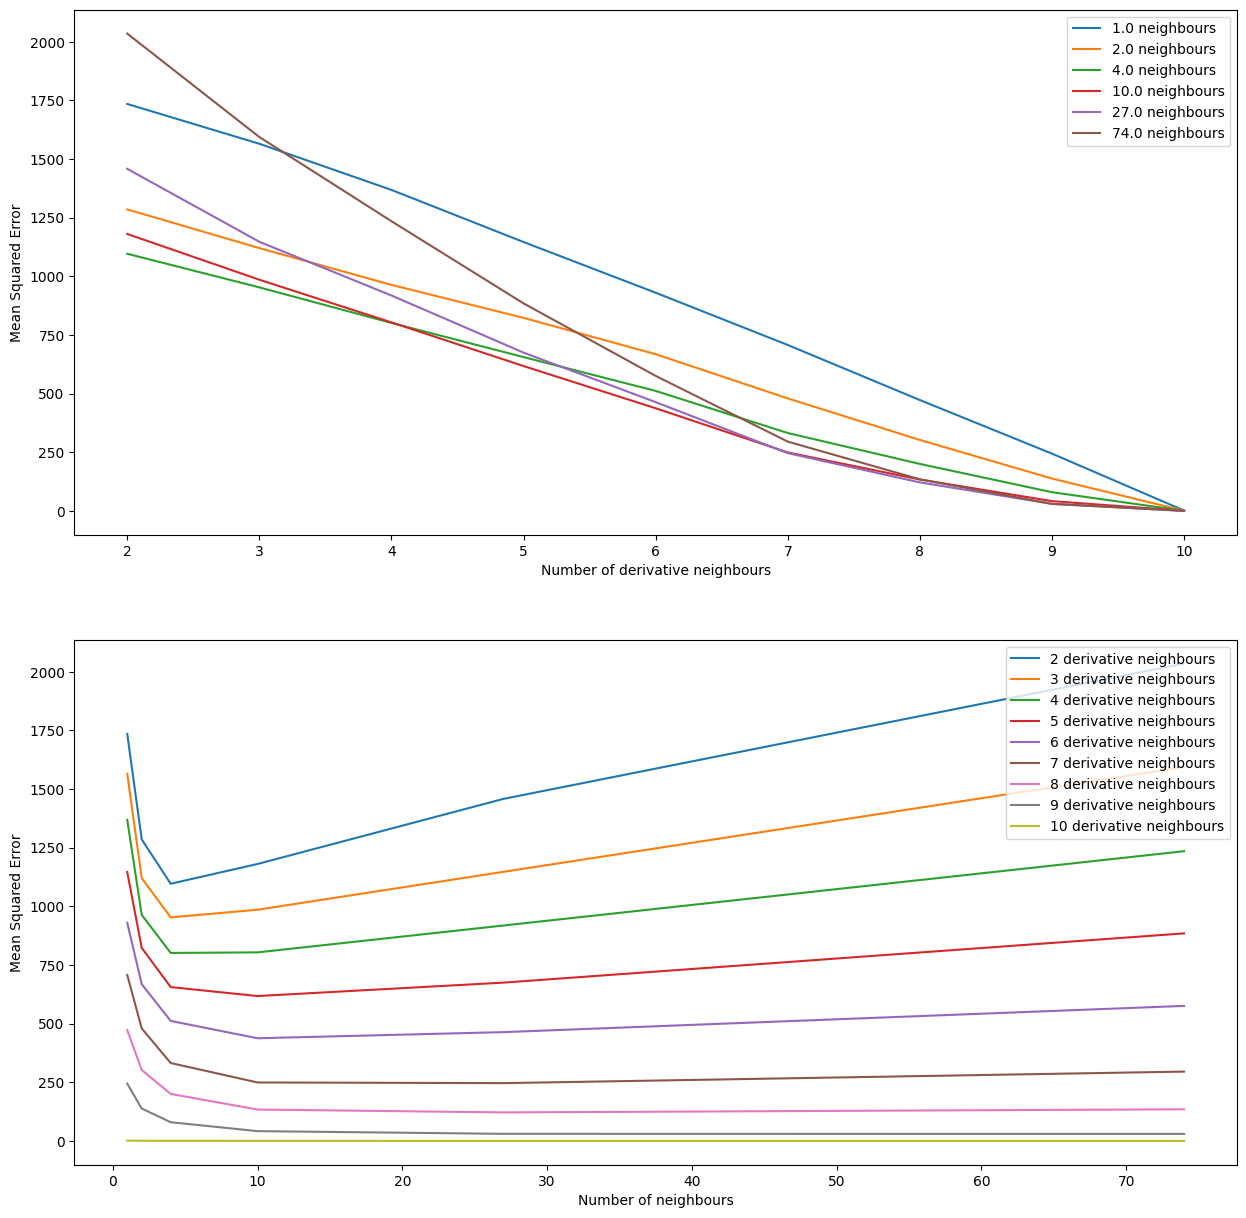

In [92]:
import matplotlib.pyplot as plt 

fig, axarr = plt.subplots(2,1, figsize=(15, 15)) 

plt.sca(axarr[0])  
[ plt.plot(number_of_n_derivative_neighbours,mse_scores[i],
           label=str(number_of_n_neighbours[i])+' neighbours'
           ) for i in range(len(mse_scores)) ]
#plt.plot(number_of_n_derivative_neighbours,mse_scores[3])
plt.xlabel('Number of derivative neighbours')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
#plt.show()

plt.sca(axarr[1])  
[ plt.plot(number_of_n_neighbours,mse_scores.T[i],
           label=str(number_of_n_derivative_neighbours[i])+' derivative neighbours'
           ) for i in range(len(mse_scores.T)) ]
#plt.plot(number_of_n_derivative_neighbours,mse_scores[3])
plt.xlabel('Number of neighbours')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.show()

Text(0.5, 0, 'Number of derivative neighbours')

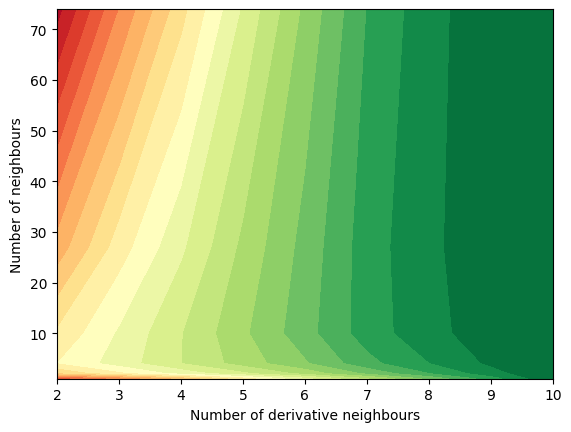

In [113]:
cmap = plt.colormaps['RdYlGn_r']
plt.contourf(
    number_of_n_derivative_neighbours,
    number_of_n_neighbours, 
    mse_scores, 
    levels=[ i for i in range(0,2200,100)],
    cmap = cmap)
plt.ylabel('Number of neighbours')
plt.xlabel('Number of derivative neighbours')